In [1]:
# Preprocessing
import pandas as pd
import tables
import time
import numpy as np
import gc
from tqdm import tqdm_notebook
from data_processing import get_data_2dprojection
import os

In [2]:
#DATA_DIR = '/storage/home/vprov/JUNO/JUNO_students/data/'
#TRAIN_DIR = '/srv/hd5/data/vprov/data/phase_1/train/'
TRAIN_DIR = '~/data/data_dir/'
tr_lpmt_hits = pd.read_hdf(TRAIN_DIR + 'lpmt_hits.h5', mode='r') 
tr_spmt_hits = pd.read_hdf(TRAIN_DIR + 'spmt_hits.h5', mode='r')
tr_pos = pd.read_csv(TRAIN_DIR + 'lpmt_pos.csv') 
tr_spmt_pos = pd.read_csv(TRAIN_DIR + 'spmt_pos.csv') 
tr_true_info = pd.read_csv(TRAIN_DIR + 'true_info.csv')

In [4]:
tr_pos = pd.concat([tr_pos, tr_spmt_pos])

In [10]:
#data_lpmt, event_to_id = get_data_2dprojection(tr_lpmt_hits[:10000], 
#                                                        tr_spmt_hits[:10000], 
#                                                        tr_pos, 
#                                                        tr_true_info,
#                                                        use_spmt=True)

In [17]:
events = tr_lpmt_hits['event'].unique()

In [91]:
rg = np.arange(0,100000,30000)

In [6]:
LTRAIN = '/mnt/iprovilkov/data_dir/npdata/'

In [49]:
for start, end  in zip(rg[:-1], rg[1:]):
    data_lpmt, event_to_id = get_data_2dprojection(tr_lpmt_hits[(tr_lpmt_hits['event'] > start) & (tr_lpmt_hits['event'] < end)], 
                                                tr_spmt_hits[(tr_spmt_hits['event'] > start) & (tr_spmt_hits['event'] < end)], 
                                                tr_pos, 
                                                tr_true_info[(tr_true_info['evtID'] > start) & (tr_true_info['evtID'] < end)],
                                                use_spmt=True)
    np.save(LTRAIN + '1_' + str(start), data_lpmt)

Make projection
Starting cycle...



Make projection
Starting cycle...


In [92]:
rg

array([    0, 30000, 60000, 90000])

In [52]:
#np.save(TRAIN_DIR + 'lpmt_2d_1802', data_lpmt)

In [9]:
data_lpmt = np.load(LTRAIN + '1_' + str(rg[0]) + '.npy')

In [10]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [11]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [12]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 369695406835846233, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11281429300
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10006528746308054681
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0a93:00:00.0, compute capability: 3.7"]

In [15]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [16]:
#tr_true_info['id'] = [event_to_id[evtID] for evtID in tr_true_info['evtID']]

In [17]:
tr_true_info[:3]

,E,R,evtID,x,y,z
0,4.747791,14610.378,0,8290.779,11995.6180,911.74286
1,3.919721,14630.141,1,11397.632,5407.4497,-7409.08200
2,6.823932,14573.132,2,14063.338,-3812.8540,246.65280


In [18]:
rg

array([    0, 30000, 60000, 90000])

In [19]:
y_val = tr_true_info[(tr_true_info['evtID'] > rg[0]) & (tr_true_info['evtID'] < rg[1])][['E']].values

In [21]:
#y_val = np.load('/srv/hd5/data/vprov/y_val.np.npy')
#data_lpmt = np.load('/srv/hd5/data/vprov/lpmt_proj.np.npy')

In [22]:
data_lpmt.shape

(29999, 151, 151, 1)

In [23]:
#data_lpmt = data_lpmt.reshape((*data_lpmt.shape, 1))
#data_lpmt = data_lpmt.reshape((16000,151,151,1))

In [24]:
import keras
import keras.layers as L
from keras.models import Sequential

Using TensorFlow backend.


In [25]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [97]:
model = Sequential()
model.add(L.Conv2D(filters=128, kernel_size=(3,3),activation='relu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=128, kernel_size=(3,3),activation='relu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=256, kernel_size=(3,3),activation='relu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=256, kernel_size=(3,3),activation='relu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=512, kernel_size=(3,3),activation='relu'))
#model.add(L.Dropout(0.3))
model.add(L.Flatten())
model.add(L.Dense(512, activation='relu'))
#model.add(L.Dropout(0.3))
model.add(L.Dense(256, activation='relu'))
model.add(L.Dense(128, activation='relu'))
model.add(L.Dense(1))

In [104]:
from keras.optimizers import Adam
opt = Adam()

In [105]:
model.compile(loss='mean_squared_error', optimizer=opt)

In [106]:
model.build(input_shape=(None, 151,151,1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 149, 149, 128)     1280      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 128)       147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 256)       295168    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 256)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 256)       590080    
__________

In [107]:
#X_train, X_test, y_train, y_test = train_test_split(data_lpmt, y_val, test_size=0.2, random_state=45)

In [108]:
logdir = 'log_1603E.csv'

In [109]:
!rm log_1603E.csv

rm: cannot remove 'log_1603E.csv': No such file or directory


In [110]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger(logdir, append=True, separator=';')

In [111]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)

In [112]:
#out = model.fit(X_train, y_train, batch_size=32, 
#                epochs=30, 
#                callbacks=[csv_logger, reduce_lr], 
#                validation_data=(X_test, y_test))

In [ ]:
import gc
for i in range(5):
    for start, end in zip(rg[:-1], rg[1:]):
        data_lpmt = np.load(LTRAIN + '1_' + str(start) + '.npy')
        y_val = tr_true_info[(tr_true_info['evtID'] > start) & (tr_true_info['evtID'] < end)][['E']].values
        X_train, X_test, y_train, y_test = train_test_split(data_lpmt, y_val, test_size=0.2, random_state=45)
        out = model.fit(X_train, y_train, batch_size=32, 
                epochs=30,
                callbacks=[csv_logger, reduce_lr],
                validation_data=(X_test, y_test))
    gc.collect()

Train on 23999 samples, validate on 6000 samples
Epoch 1/30
23999/23999 [==============================] - 134s 6ms/step - loss: 7.2270 - val_loss: 0.1427
Epoch 2/30
23999/23999 [==============================] - 134s 6ms/step - loss: 0.1945 - val_loss: 0.0893
Epoch 3/30
23999/23999 [==============================] - 134s 6ms/step - loss: 0.1661 - val_loss: 0.0996
Epoch 4/30
23999/23999 [==============================] - 134s 6ms/step - loss: 0.1451 - val_loss: 0.2199
Epoch 5/30
23999/23999 [==============================] - 134s 6ms/step - loss: 0.1597 - val_loss: 0.2153
Epoch 6/30
23999/23999 [==============================] - 134s 6ms/step - loss: 0.1442 - val_loss: 0.0691
Epoch 7/30
23999/23999 [==============================] - 134s 6ms/step - loss: 0.1260 - val_loss: 0.2149
Epoch 8/30
23999/23999 [==============================] - 134s 6ms/step - loss: 0.1449 - val_loss: 0.0780
Epoch 9/30
23999/23999 [==============================] - 134s 6ms/step - loss: 0.1337 - val_loss: 0.10

23999/23999 [==============================] - 136s 6ms/step - loss: 0.0462 - val_loss: 0.0648
Epoch 2/30
23999/23999 [==============================] - 136s 6ms/step - loss: 0.0407 - val_loss: 0.0647
Epoch 3/30
23999/23999 [==============================] - 137s 6ms/step - loss: 0.0382 - val_loss: 0.0642
Epoch 4/30
23999/23999 [==============================] - 137s 6ms/step - loss: 0.0364 - val_loss: 0.0635
Epoch 5/30
23999/23999 [==============================] - 139s 6ms/step - loss: 0.0349 - val_loss: 0.0640
Epoch 6/30
23999/23999 [==============================] - 138s 6ms/step - loss: 0.0336 - val_loss: 0.0640
Epoch 7/30
23999/23999 [==============================] - 136s 6ms/step - loss: 0.0325 - val_loss: 0.0644
Epoch 8/30
23999/23999 [==============================] - 137s 6ms/step - loss: 0.0313 - val_loss: 0.0644
Epoch 9/30
23999/23999 [==============================] - 137s 6ms/step - loss: 0.0303 - val_loss: 0.0648
Epoch 10/30
23999/23999 [==============================] 

In [116]:
import pandas as pd
import matplotlib.pyplot as plt

In [117]:
cs = pd.read_csv(logdir, sep=';')

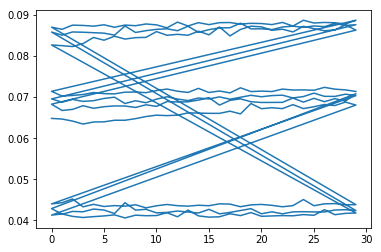

In [118]:
plt.plot(cs['epoch'].values, cs['val_loss'].values)

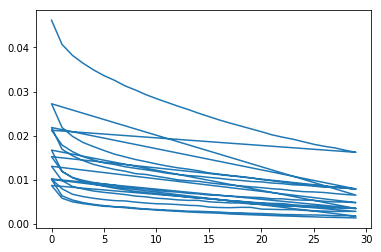

In [119]:
plt.plot(cs['epoch'].values, cs['loss'].values)

In [48]:
#cs.plot(x='epoch',y='val_loss')
#plt.ylim((0, 100000))

In [120]:
model.save_weights('16_03_E.h5')

In [33]:
model.load_weights('18_02_E.h5')

In [ ]:
print("+")

In [50]:
with open("16_03_E.json", "w") as json_file:
    json_file.write(model.to_json())

In [121]:
from sklearn.metrics.pairwise import paired_euclidean_distances

In [122]:
from sklearn.metrics import mean_squared_error

In [123]:
# in mm
#test_results = paired_euclidean_distances(model.predict(X_test), y_test)

In [124]:
preds = np.maximum(model.predict(X_test), 0)
test_resultsE = mean_squared_error(preds[:,0], y_test[:,0])
#test_resultsR = mean_squared_error(preds[:,1], y_test[:,1])

In [125]:
test_resultsE.mean()

0.07138068793407519

(-1, 1)

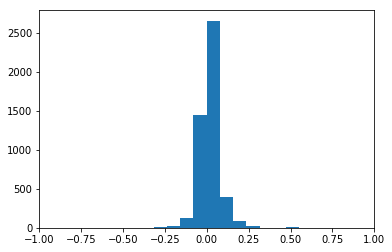

In [50]:
plt.hist((preds[:,0] - y_test[:,0])/y_test[:,0], bins=100)
plt.xlim((-1,1))

In [126]:
%run root_reader.py

In [128]:
# Sigma tests:
#from root_reader import convert_from_root

In [129]:
root_data_path = '/mnt/iprovilkov/data_dir/0MeV_lpmt_hits.h5'

In [170]:
def test_sigmas(model, test_dir='/mnt/iprovilkov/data_dir/', test_column='E'):
    sigmas = {}
    MSEs = {}
    predictions = {}
    for energy in tqdm(range(10)):
        try:
            data_lpmt = np.load(test_dir + str(energy) + 'data_lpmt.npy')
            true_info = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'true_info.csv')
        except: 
            lpmt_hits = pd.read_hdf(test_dir + str(energy)+'MeV_'+ 'lpmt_hits.h5', mode='r') 
            spmt_hits = pd.read_hdf(test_dir + str(energy)+'MeV_'+'spmt_hits.h5', mode='r')
            pos = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'lpmt_pos.csv') 
            spmt_pos = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'spmt_pos.csv') 
            true_info = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'true_info.csv')
            data_lpmt, event_to_id = get_data_2dprojection(lpmt_hits, 
                                    spmt_hits, 
                                    pos, 
                                    true_info,
                                    use_spmt=True)
            np.save(test_dir+str(energy)+'data_lpmt', data_lpmt)
        preds = np.maximum(model.predict(data_lpmt), 0)
        y_test = true_info[test_column]
        
        predictions[energy] = preds
        MSEs[energy] = mean_squared_error(preds, y_test)
        
        sigmas[energy] = np.var(preds - preds.mean())
    print("+")
    return sigmas, MSEs, predictions

In [171]:
sigmas, MSEs, predictions = test_sigmas(model)

100%|██████████| 10/10 [00:37<00:00,  3.76s/it]

+


In [173]:
sigmas

{0: 0.02895837,
 1: 0.029570192,
 2: 0.031224858,
 3: 0.033373803,
 4: 0.037357513,
 5: 0.042868596,
 6: 0.08647771,
 7: 0.12399483,
 8: 0.12814525,
 9: 0.110840105}

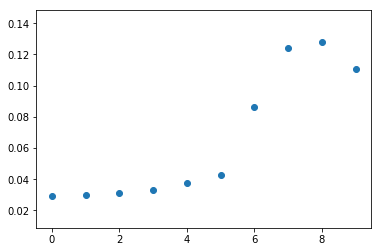

In [174]:
plt.scatter(sigmas.keys(), sigmas.values())

In [157]:
sigmas

{0: 0.17017159,
 1: 0.17195986,
 2: 0.17670557,
 3: 0.18268499,
 4: 0.19328092,
 5: 0.20704733,
 6: 0.29407093,
 7: 0.35212898,
 8: 0.3579738,
 9: 0.33292657}

In [156]:
MSEs

{0: 0.03796871097615623,
 1: 0.030383979658258297,
 2: 0.031718544577242117,
 3: 0.033721130120994,
 4: 0.03756203330641611,
 5: 0.04311261195163359,
 6: 0.08648203742928379,
 7: 0.12410257893058468,
 8: 0.12817486926491023,
 9: 0.1111514193277844}

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

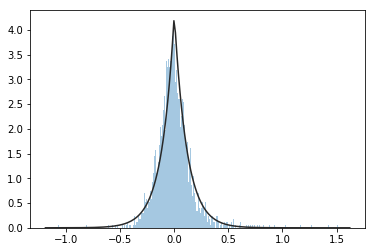

In [149]:
sns.distplot(predictions[1] - predictions[1].mean(), kde=False, fit=stats.laplace, bins=300)

In [69]:
anti_ejection_mask = (abs(diff)<0.3) & (y_test[:,0] < 1.5) & (y_test[:,0] > 0.5)

NameError: name 'diff' is not defined

In [70]:
plt.scatter(y_test[:,0][anti_ejection_mask], preds[:,0][anti_ejection_mask])

NameError: name 'anti_ejection_mask' is not defined

In [71]:
np.std((preds[:,0][anti_ejection_mask] - y_test[:,0][anti_ejection_mask])/y_test[:,0][anti_ejection_mask])

0.11789867748896025

In [76]:
#test_resultsR.mean()

101617.658293631

In [97]:
#test_resultsR.mean() /100000 + test_resultsE.mean() * 100

In [98]:
# Make a submission
TEST_DIR = '/srv/hd5/data/vprov/data/phase_1/test/'
te_lpmt_hits = pd.read_hdf(TEST_DIR + 'test_l_hits.h5', mode='r')
te_spmt_hits = pd.read_hdf(TEST_DIR + 'test_s_hits.h5', mode='r')

In [99]:
len(te_lpmt_hits['event'].unique())

5000

In [101]:
te_data_lpmt, te_event_to_id = get_data_2dprojection(te_lpmt_hits, 
                                                              te_spmt_hits, 
                                                              tr_pos, 
                                                              tr_true_info,
                                                              use_spmt=True, time=True)

Make projection
Starting cycle...


In [102]:
te_data_lpmt.shape

(5000, 151, 151, 3)

In [91]:
#te_data_lpmt = te_data_lpmt.reshape((*te_data_lpmt.shape, 1))

In [103]:
test_answer = model.predict(te_data_lpmt)

In [104]:
test_answer = np.maximum(test_answer, 0)

In [105]:
test_answer[:3]

array([[3.1486816],
       [6.8654876],
       [2.4813795]], dtype=float32)

In [111]:
forR = pd.read_csv('./submissions/03_02_mix.csv')

In [112]:
forR[:3]

,E,R,evtID
0,13554.038,13554.038,16000
1,15458.701,15458.701,16001
2,8600.067,8600.067,16002


In [113]:
x = te_lpmt_hits["event"].unique()
pred = pd.DataFrame({
            "evtID": x,
            "R": forR['R'],
            "E": test_answer[:,0]
    })

In [114]:
pred[:3]

,E,R,evtID
0,3.148682,13554.038,16000
1,6.865488,15458.701,16001
2,2.481380,8600.067,16002


In [115]:
pred.to_csv('./submissions/03_02_mix.csv', index=None)

In [109]:
test_resultsE

0.10578900484730176

In [112]:
np.maximum(preds[:,0], 0) - y_test[:,0]

array([ 0.07827002,  0.16265111,  0.09557195, ...,  0.29406197,
        0.4023328 , -0.02289935])

Text(0.5,0,'Energy error, mEv')

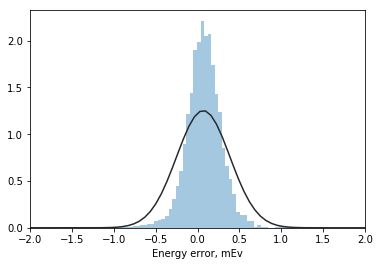

In [119]:
sns.distplot(np.maximum(preds[:,0], 0) - y_test[:,0], kde=False, fit=stats.norm, bins=300)
plt.xlim((-2,2))
plt.xlabel("Energy error, mEv")

In [122]:
(preds-y_test).mean() / y_test.mean()

0.012328221320621629

In [49]:
test_results.mean() / 10

40.478805095559686

In [53]:
results = model.predict(X_test)

In [54]:
xs = results[:,0] - y_test[:,0]

(-1000, 1000)

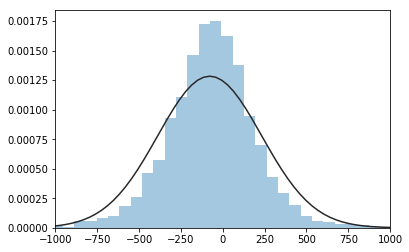

In [57]:
sns.distplot(xs, kde=False, fit=stats.norm, bins=100)
plt.xlim(-1000,1000)

In [59]:
abs(xs).mean()/10

21.422522304369796

In [ ]:
#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
## load weights into new model
#loaded_model.load_weights("model.h5")
#print("Loaded model from disk")
# 
## evaluate loaded model on test data
#loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#score = loaded_model.evaluate(X, Y, verbose=0)

In [ ]:
# Adversarial example с нормальным текстом
# Кэширование перевода
# Bert в телефоне